# Challenge

For the [PHM challenge of 2021](https://phm-europe.org/data-challenge) we need to classify healthy and faulty (5 faults in total) behavior of a test-bed, utilising sensor data from a set of 70 experiments, each having a duration between 1 to 3 hours.
Following is a description of the testbed and the dataset:

## System Description
The testbed under consideration represents a typical component of a large-scale quality-control pipeline and can be easily integrated in multiple different industry 4.0 manufacturing lines.

More specifically, the machine consists of a 4-axis SCARA-robot picking up electrical fuses with a vacuum gripper, from a feeder to a fuse-test-bench. On this fuse-test-bench, first it assesses whether the fuse is conducting electricity. If the first test was successful, the fuse gets heated up by applying a current of 200mA for a time interval of 1.5s. The heating up is measured by a thermal camera. After the tests, the fuse is moved back into the feeder with two conveyor belts. A picture of the machine and an illustration of the main steps involved in the quality-control process are shown below:

![caption](./imm/Systeme-description-768x611.png)


1. The fuses are first picked up by a robotic arm.
2. Fuses are then left under the visual field of a thermal-camera responsible for finding signs of overheating or degradation.
3. Once the analysis is terminated, fuses are placed on a conveyor belt and sorted by a robotic bar.
4. Fuses are moved by the large conveyor belt (green in the figure) to a (5) small conveyor belt that transports them back to the (6) feeder where fuses are stored before restarting the cycle.

Both process control and health data acquisition are implemented with CSEM VISARD. The machine is monitored by an array of 50 sensors recording the evolution of a number of quantities of interest to establish the health state of the machine in real-time. The sensor data is aggregated over a time window of 10s. For each window and sensor, one statistical data point is calculated in order to reduce the data size.

The main components of the experimental rig are the following.

- 4-axis SCARA robot fuse feeder, feeding movement electrically powered, barrier to hold back fuses pneumatically powered
- thermal camera (382×288 pixel, 0-250 deg C) camera to detect fuses on feeder (1280×1024 pixel)
- EC motor for big conveyor belt
- EC motor for fuse selector
- DC motor for small conveyor belt
- Vacuum pump for robot gripper
- Pressure pump for feeder barrier
- several valves for the pneumatics system

The machine can be operated under different regimes and conditions. Under its nominal working regime, there are no throughput defects at any level of the quality-control-pipeline, from picking-up the fuses to their transportation and analysis. However, different artificial failure modes can be artificially injected by manually altering the behaviour of one or more components. Such deviations from the machines’ normal working condition can be induced at different levels, for instance:

1. Modification of the operating mode of the robotic arm picking up the fuses,
2. Introduction of a pressure leakage on the pneumatic system
3. Altering the speed of the conveyor belts
In total, up to 9 failure cases are introduced. Each of them affects the sensor readings in a different way and one of the goals of the challenge is to rank the signals according to their level of correlation with the failure mode being considered.

## Dataset
The experimental dataset is composed of a set of 50 signals, each one describing the evolution over time of a quantity of interest. Each experiment can run from ≈ 1 to ≈ 3 hours.

These signals can be divided into three categories:

- Machine health monitoring signals: Pressure, Vacuum, FuseHeatSlope,
- Environment monitoring signals: Temperature, Humidity, …
- Others: CPUTemperature, ProcessMemoryConsumption, …
Each signal is associated with a specific set of fields describing different signal’ features extracted from that signal by the automated data acquisition process.

For example, the signal DurationPicktoPick, which measures the duration between the time the robot picks up one fuse to when it picks up the next one, is described by the following features:
- vCnt (number of samples recorded in a fixed time-window), 
- vFreq (Sampling frequency within the same time-window), 
- vMax (Maximum value recorded within the time-window), 
- vMin (Minimum value recorded within the time-window), 
- vTrend (time series trend within the time-window) and value (Mean value recorded within the time-window).

Notice that not all the measurements have all the features, for instance, the signal FeederAction1 has only the vCnt feature. This is because certain signals can not be sampled at regular frequencies, hence, the corresponding signals simply describe the occurrence of a certain event at a certain time. For all the signals, the aforementioned features (vCnt, vFreq….) are extracted from a window of 10 seconds. A separate file listing the names of the features associated with each measurement is provided.

Experimental data have been acquired under fault-free operating conditions and, with the support of domain expertise, experiments have also been generated with a variety of seeded faults under controlled conditions.

Fault-free experiments (having label 0) represent the behaviour of the machine during its normal operating regime. In this case, the machine does not present any problem and runs smoothly. Fault-free experiments have been acquired by using two different system parameter configurations. Yet, both system parameter configurations lead to a nominal system behaviour.

Seeded faults operating conditions are characterized by anomalous behaviour. Depending on the fault, unhealthy experiments have been labeled with 8 different labels. Each fault is characterized by an anomalous behaviour of one or or more signals.

# EDA

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedKFold

import utils
from ExtremeLearningMachine import ELM


Read data:

In [3]:
path = './Raw data/'
fields = pd.read_csv('./fields.csv', index_col = 0)

dfs = []
for file in os.listdir(path):
    
    # Get class and experiment number
    temp       = file.split('class_ ')[1]
    target     = temp.split('_')[0]
    experiment = temp.split('_')[1]
    
    # Read file
    df = utils.parse_file(pd.read_csv(path + file)) # for "NumberFuseDetected", the number of keys might vary from 6 to 7 -> different column no.
    
    # Add class and experiment no.
    df['target'] = int(target)
    df['exp']    = int(experiment)
    
    # Append to list
    dfs.append(df)
    
# Merge
df = pd.concat(dfs, axis = 0)

In [4]:
df.shape

(39611, 249)

Approximately 40k rows with 247 features (one column is the target, the other is the experiment number).

## Missing data

Let's have a look at missing data. According to the description, there should be quite a few columns with a lot of missing values

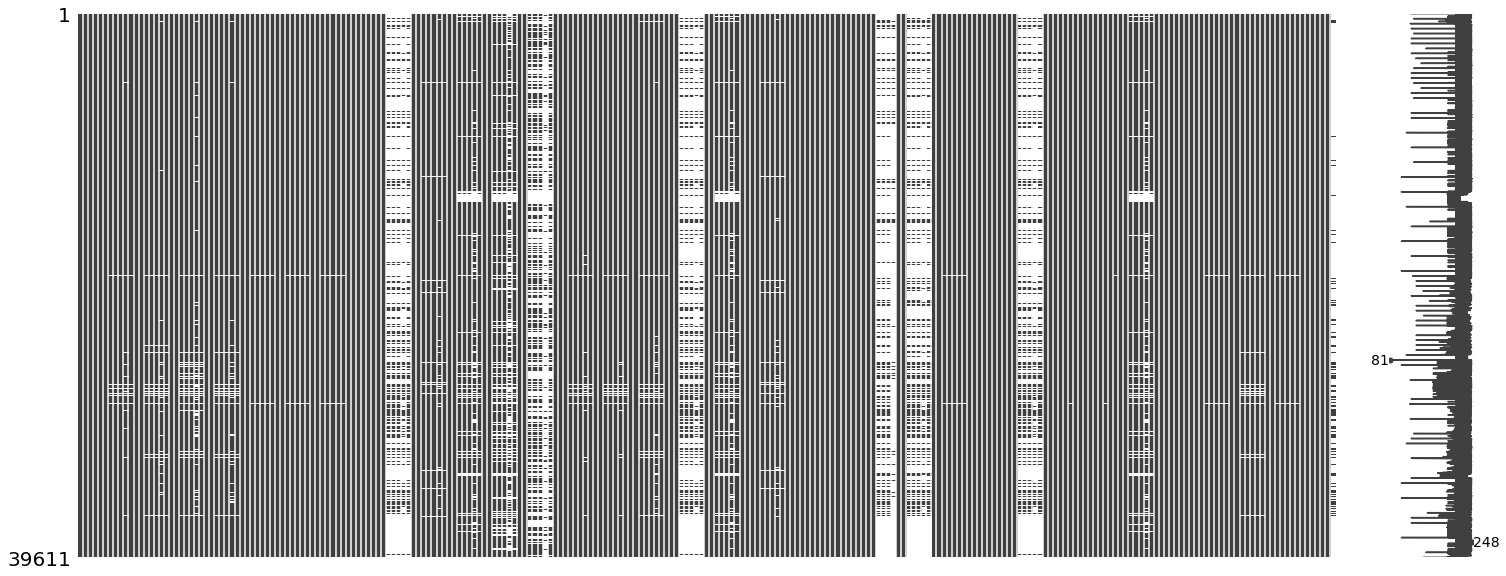

In [5]:
msno.matrix(df);

Let's make a bar chart with no. of missing values per colum:

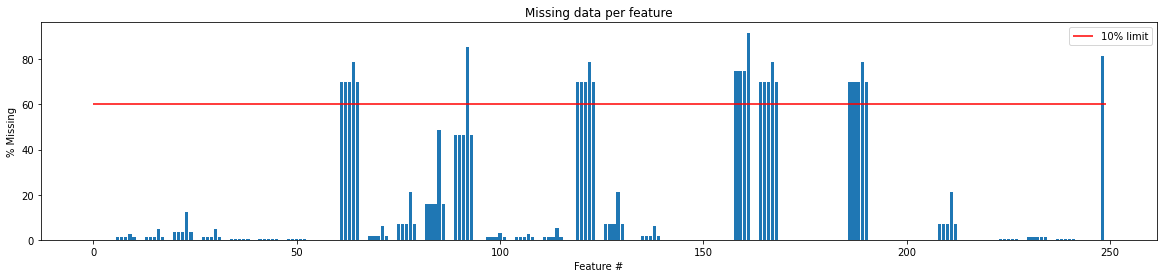

In [6]:
no_feats     = len(df.columns)
perc_missing = df.isnull().sum()/df.shape[0]*100

plt.figure(figsize = (20, 4))
plt.bar(x = range(no_feats), height = perc_missing)
plt.hlines(xmin = 0, xmax = no_feats, y = 60, color = 'r')
plt.title('Missing data per feature');
plt.xlabel('Feature #')
plt.ylabel('% Missing')
plt.legend(['10% limit']);

We need to drop quite a few columns. We'll drop everything with more than 60% missing and forward fill the rest:

In [7]:
# Drop everything with more than 60% missing
df.drop(perc_missing[perc_missing > 60].index, axis = 1, inplace = True)

# Forward fill the rest, and backward fill any remaining values (first rows in any experiment)
df.fillna(method = 'ffill', inplace = True)
df.fillna(method = 'bfill', inplace = True)

## Unique values
Let's check for unique values in all variables:

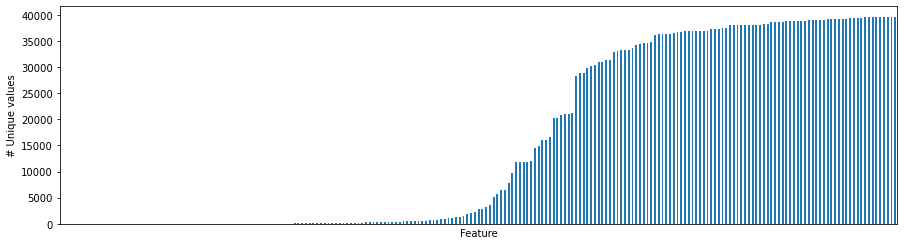

In [8]:
df.nunique().sort_values().plot.bar(figsize = (15, 4), ylabel = '# Unique values', xlabel = 'Feature', xticks = []);

There are constant features. Let's see how many:

In [9]:
u_vals  = df.nunique()
to_drop = u_vals[u_vals <= 1]
to_drop

ErrorFrame_vCnt                            1
ErrorFrame_vFreq                           1
FuseOutsideOperationalSpace_vMin           1
LightBarrieActiveTaskDuration2_vCnt        1
LightBarrieActiveTaskDuration2_vFreq       1
LightBarrierActiveTaskDuration1b_vCnt      1
LightBarrierActiveTaskDuration1b_vFreq     1
LightBarrierPassiveTaskDuration1b_vCnt     1
LightBarrierPassiveTaskDuration1b_vFreq    1
LightBarrierPassiveTaskDuration2_vCnt      1
LightBarrierPassiveTaskDuration2_vFreq     1
LightBarrierTaskDuration_vCnt              1
LightBarrierTaskDuration_vFreq             1
dtype: int64

Let's drop them:

In [10]:
df.drop(to_drop.index.to_list(), axis = 1, inplace = True)

## vfreq and vcnt features

Quite possibly these two contain duplicate information. Logging frequency goes up, so does the number of so does the number of samples recorded in a time window. Let's have a look:

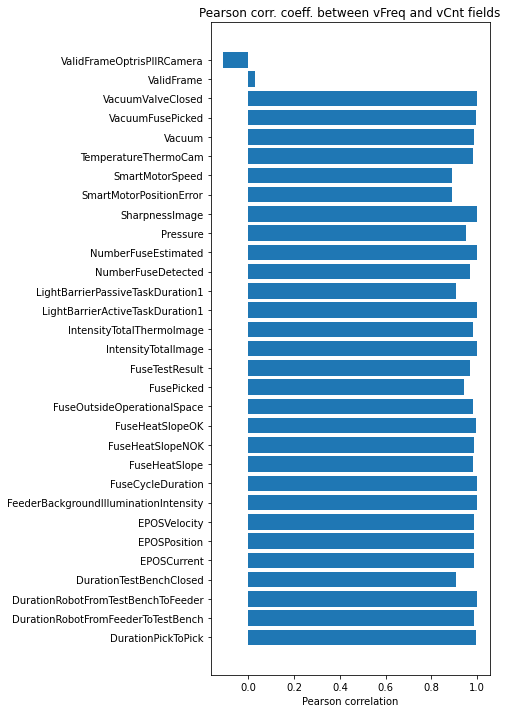

In [11]:
f = []
c = []

# Loop over all fields
for field in fields.index:
    
    # Make frequency and count column names
    freq_col = field + '_vFreq'
    cnt_col  = field + '_vCnt'
    
    # If both exist in the dataset
    if (freq_col in df.columns) and (cnt_col in df.columns):
        
        # Compute Pearson correlation coefficient
        pearson_corr = df[[freq_col, cnt_col]].corr().iloc[0, 1]
        
        f.append(field)
        c.append(pearson_corr)

# Plot results
plt.figure(figsize = (5, 12))
plt.barh(f, c);
plt.xlabel('Pearson correlation');
plt.title('Pearson corr. coeff. between vFreq and vCnt fields');

Indeed. Very high correlation for all fields apart from the ValidFrame and ValidFramePIIRCamera (for the latter is even negative). Arbitrarily, we will drop the vCnt features for all other fields:

In [12]:
to_drop = []

for field in fields.index:
    
    if field not in ['ValidFrame', 'ValidFrameOptrisPIIRCamera']:
        
        cnt_col  = field + '_vCnt'
        
        if cnt_col in df.columns: 
            to_drop.append(cnt_col)
            
df.drop(to_drop, axis = 1, inplace = True)

## Correlated features

As in any heavily sensed mechanical systems, there will be features that are highly correlated.

There should be two kinds of correlations:
1. Correlations among features extracted from the same signal (vStd and vMax or example),
2. Correlations among features from different signals (the vMax value for different signals for example.

We need to check for both

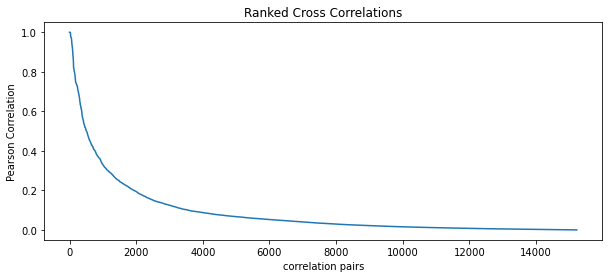

In [14]:
lbls_drop = utils.get_redundant_pairs(df)
c         = df.corr().abs().unstack().drop(labels=lbls_drop).sort_values(ascending = False)
plt.figure(figsize = (10, 4))
plt.plot(range(len(c)), c)
plt.xlabel('correlation pairs');
plt.title('Ranked Cross Correlations')
plt.ylabel('Pearson Correlation');

Indeed, there are quite a few high pearson values. We'll drop one feature in every pair with a Pearson correlation higher than 0.95:

In [15]:
# Get correlation pairs w/ Pearson correlation at least equal to 0.95
cor_feats = c[c >= 0.95].reset_index()[['level_0', 'level_1']]

# Get features that exist in level_0 but not in level_1
to_drop   = list(set(cor_feats['level_0']).difference(set(cor_feats['level_1'])))

# Delete them
df.drop(to_drop, axis = 1, inplace = True)

In [16]:
df.shape

(39611, 156)

We removed approximately 40% of the features.

# Modelling

We will follow 'sliding window' approach, to provide some context of the time-series for the learning algorithm, and the usual preprocessing required for the ELM.

We'll perform nested CV for the full model selection and error estimation process, and we'll monitor the Area Under the Receiver Operating Characteristic (AUROC), weighted by support for class imbalance.

We'll also stratify on the 'experiment level', meaning that we'll separate entire experiments for the train/val/test splits.

In [19]:
inner_folds = 5 # Model selection folds
outer_folds = 5 # Error estimation folds

# Hyperparameter set dict
hyperparams = dict(windows    = np.append(np.logspace(start = np.log10(1), stop = np.log10(30), num = 5, dtype = int), 0),
                   elm_hidden = np.logspace(start = np.log10(10), stop = np.log10(5000), num = 10, dtype = int))

# Make splitters
skf_inner = StratifiedKFold(n_splits = inner_folds, shuffle = True, random_state = 123)
skf_outer = StratifiedKFold(n_splits = outer_folds, shuffle = True, random_state = 546)

# Make predictors and target
cols = [col for col in df.columns if (col != 'exp' and col != 'target')]
X, y = df[cols].values, df['target'].values

# Compute groups for stratified splits (stratified split on the experiment level)
skf_groups = df.groupby(['exp', 'target'], sort = False).ngroup().values

# Outer k-folds
test_scores = []
for outer_fold, (t_idx, v_idx) in enumerate(skf_outer.split(X, skf_groups)):
            
    # Set initial best hyperparams and score
    best_score, best_window, best_elm_size = -np.Inf, None, None
    
    # Hyperparameter selection loop
    for window in hyperparams["windows"]:
        
        # Apply sliding window on a new hyperparameter set only
        X_t_sw = utils.make_sliding_window(X[t_idx, :], skf_groups[t_idx], window)
        
        # Loop over hidden sizes
        for elm_hidden in hyperparams["elm_hidden"]:

            # Run inner k-fold
            scores = [utils.train_predict(X_t_sw, y[t_idx], elm_hidden, train_idx, val_idx) \
                        for train_idx, val_idx in skf_inner.split(X_t_sw, skf_groups[t_idx])]            
            mean_score, std_score = np.mean(scores), np.std(scores)
            
            # Check if this configuration is better than the previous
            if mean_score > best_score:
                best_window, best_elm_size = window, elm_hidden
                best_score, best_std       = mean_score, std_score
    
    # Re-train w/ the best hyperparams and predict on the test set
    X_sw    = utils.make_sliding_window(X, skf_groups, best_window)
    t_score = utils.train_predict(X_sw, y, best_elm_size, t_idx, v_idx)
    test_scores.append(t_score)
    
    # Print results
    print(f'Outer fold {outer_fold + 1:2d} | Best Window {best_window:2d}, Best Hidden Layer No. {best_elm_size:5d} | CV Score: {best_score:.3} +- {best_std:.2}, Test set Score: {t_score:.3}')

Outer fold  1 | Best Window  1, Best Hidden Layer No.  4999 | CV Score: 0.978 +- 0.002, Test set Score: 0.983
Outer fold  2 | Best Window  1, Best Hidden Layer No.  4999 | CV Score: 0.977 +- 0.0022, Test set Score: 0.98
Outer fold  3 | Best Window  0, Best Hidden Layer No.  4999 | CV Score: 0.978 +- 0.0012, Test set Score: 0.981
Outer fold  4 | Best Window  0, Best Hidden Layer No.  4999 | CV Score: 0.977 +- 0.0014, Test set Score: 0.978
Outer fold  5 | Best Window  1, Best Hidden Layer No.  4999 | CV Score: 0.977 +- 0.002, Test set Score: 0.982


The results are very consistent. We can use 4999 (5000) neurons for the hidden layer of the ELM with a window of 1. 5000 is the upper limit of neurons, meaning that if we allow higher values the score might improve even more, but this is definitely satisfactory.

Now we can train on the entire dataset and save the model:

In [ ]:
final_window   = 1
final_layer_sz = 5000

# Apply sliding window
X_sw = utils.make_sliding_window(X, skf_groups, final_window)

# Scale
scaler = utils.MinMaxScaler(feature_range = (-1, 1))
X_sw   = scaler.fit_transform(X_sw)

# One hot encode the targets
enc = OneHotEncoder(handle_unknown = 'ignore')
enc.fit(y.reshape(-1, 1))
y_oh = enc.transform(y.reshape(-1, 1)).toarray()

# Train ELM
elm = ELM(input_size = X.shape[1], hidden_size = elm_hidden)
elm.fit(X, y_oh)